### Load Libraries and Data

In [55]:
%matplotlib inline

import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt



pd.options.display.max_rows = 10
sns.set(style='ticks', context='talk')

In [74]:
fp = 'data/nba.csv'

if not os.path.exists(fp):
    tables = pd.read_html("https://www.hockey-reference.com/leagues/NHL_2018_games.html")
    games = tables[0]
    games.to_csv(fp)
else:
    games = pd.read_csv(fp)

    
games.columns = ['game_id', 'date', 'away_team', 'away_goals', 'home_team', 'home_goals', 'Overtime','Attendance','LOG', 'Notes']
games.head()

,game_id,date,away_team,away_goals,home_team,home_goals,Overtime,Attendance,LOG,Notes
0,0,2017-10-04,Calgary Flames,0,Edmonton Oilers,3,NaN,18347,2:34,NaN
1,1,2017-10-04,St. Louis Blues,5,Pittsburgh Penguins,4,OT,18652,2:38,NaN
2,2,2017-10-04,Philadelphia Flyers,5,San Jose Sharks,3,NaN,17562,2:27,NaN
3,3,2017-10-04,Toronto Maple Leafs,7,Winnipeg Jets,2,NaN,15321,2:33,NaN
4,4,2017-10-05,Arizona Coyotes,4,Anaheim Ducks,5,NaN,17174,2:38,NaN


### Add Overtime Binary and Remove Columns

In [75]:
## Replace Overtime with Binary
games.Overtime.replace(to_replace=dict(NA=0, OT=1), inplace=True)
games.Overtime.fillna(0, inplace=True)

In [76]:
games.head()

,game_id,date,away_team,away_goals,home_team,home_goals,Overtime,Attendance,LOG,Notes
0,0,2017-10-04,Calgary Flames,0,Edmonton Oilers,3,0,18347,2:34,NaN
1,1,2017-10-04,St. Louis Blues,5,Pittsburgh Penguins,4,1,18652,2:38,NaN
2,2,2017-10-04,Philadelphia Flyers,5,San Jose Sharks,3,0,17562,2:27,NaN
3,3,2017-10-04,Toronto Maple Leafs,7,Winnipeg Jets,2,0,15321,2:33,NaN
4,4,2017-10-05,Arizona Coyotes,4,Anaheim Ducks,5,0,17174,2:38,NaN


In [77]:
games.groupby('Overtime').count()

,game_id,date,away_team,away_goals,home_team,home_goals,Attendance,LOG,Notes
Overtime,,,,,,,,,
0,975,975,975,975,975,975,975,975,0
1,193,193,193,193,193,193,193,193,0
SO,103,103,103,103,103,103,103,103,0


In [78]:
games = (games.dropna(thresh=4)
    [['date', 'away_team', 'away_goals', 'home_team', 'home_goals', 'Overtime']]
    .assign(date=lambda x: pd.to_datetime(x['date']))
    .set_index('date', append=True)
    .rename_axis(["game_id", "date"])
    .sort_index())
games.head()

,,away_team,away_goals,home_team,home_goals,Overtime
game_id,date,,,,,
0,2017-10-04,Calgary Flames,0,Edmonton Oilers,3,0
1,2017-10-04,St. Louis Blues,5,Pittsburgh Penguins,4,1
2,2017-10-04,Philadelphia Flyers,5,San Jose Sharks,3,0
3,2017-10-04,Toronto Maple Leafs,7,Winnipeg Jets,2,0
4,2017-10-05,Arizona Coyotes,4,Anaheim Ducks,5,0


###  How many days did each team rest between games?

In [79]:
tidy = pd.melt(games.reset_index(),
               id_vars=['game_id', 'date'], value_vars=['away_team', 'home_team'],
               value_name='team')
tidy.head()

,game_id,date,variable,team
0,0,2017-10-04,away_team,Calgary Flames
1,1,2017-10-04,away_team,St. Louis Blues
2,2,2017-10-04,away_team,Philadelphia Flyers
3,3,2017-10-04,away_team,Toronto Maple Leafs
4,4,2017-10-05,away_team,Arizona Coyotes


In [80]:
tidy.groupby('team')['date'].diff().dt.days - 1

tidy['rest'] = tidy.sort_values('date').groupby('team').date.diff().dt.days - 1
tidy.dropna().head()

,game_id,date,variable,team,rest
7,7,2017-10-05,away_team,Pittsburgh Penguins,0.0
9,9,2017-10-05,away_team,Philadelphia Flyers,0.0
15,15,2017-10-07,away_team,Philadelphia Flyers,1.0
16,16,2017-10-07,away_team,Vegas Golden Knights,0.0
17,17,2017-10-07,away_team,Minnesota Wild,1.0


In [81]:
by_game = (pd.pivot_table(tidy, values='rest',
                          index=['game_id', 'date'],
                          columns='variable')
             .rename(columns={'away_team': 'away_rest',
                              'home_team': 'home_rest'}))
df = pd.concat([games, by_game], axis=1)
df.dropna().head()

,,away_team,away_goals,home_team,home_goals,Overtime,away_rest,home_rest
game_id,date,,,,,,,
15,2017-10-07,Philadelphia Flyers,3,Anaheim Ducks,2,1,1.0,1.0
16,2017-10-07,Vegas Golden Knights,2,Arizona Coyotes,1,1,0.0,1.0
18,2017-10-07,Winnipeg Jets,3,Calgary Flames,6,0,2.0,2.0
19,2017-10-07,Columbus Blue Jackets,1,Chicago Blackhawks,5,0,0.0,1.0
20,2017-10-07,Tampa Bay Lightning,4,Florida Panthers,5,0,0.0,0.0


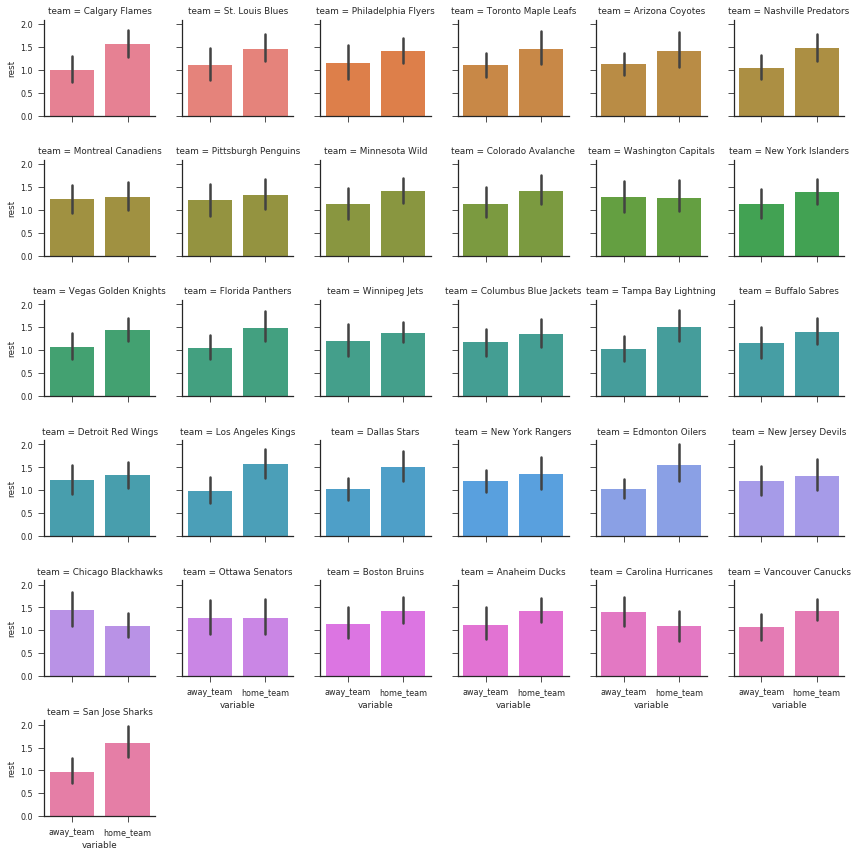

In [82]:
sns.set(style='ticks', context='paper')
g = sns.FacetGrid(tidy, col='team', col_wrap=6, hue='team', size=2)
g.map(sns.barplot, 'variable', 'rest');

In [84]:
df['home_win'] = df['home_goals'] > df['away_goals']
df['rest_spread'] = df['home_rest'] - df['away_rest']
df.dropna().head()

,,away_team,away_goals,home_team,home_goals,Overtime,away_rest,home_rest,home_win,rest_spread
game_id,date,,,,,,,,,
15,2017-10-07,Philadelphia Flyers,3,Anaheim Ducks,2,1,1.0,1.0,False,0.0
16,2017-10-07,Vegas Golden Knights,2,Arizona Coyotes,1,1,0.0,1.0,False,1.0
18,2017-10-07,Winnipeg Jets,3,Calgary Flames,6,0,2.0,2.0,True,0.0
19,2017-10-07,Columbus Blue Jackets,1,Chicago Blackhawks,5,0,0.0,1.0,True,1.0
20,2017-10-07,Tampa Bay Lightning,4,Florida Panthers,5,0,0.0,0.0,True,0.0


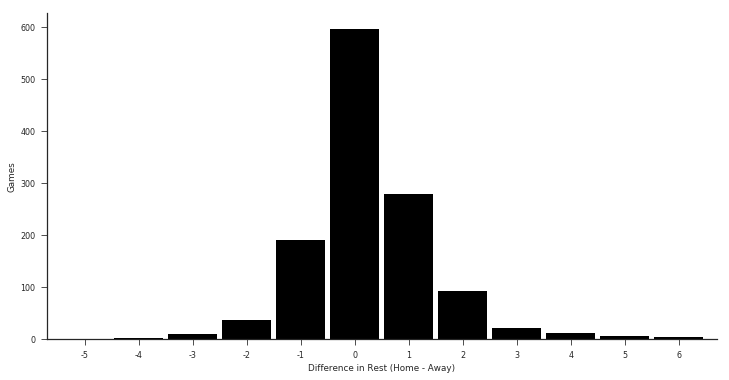

In [85]:
delta = (by_game.home_rest - by_game.away_rest).dropna().astype(int)
ax = (delta.value_counts()
    .reindex(np.arange(delta.min(), delta.max() + 1), fill_value=0)
    .sort_index()
    .plot(kind='bar', color='k', width=.9, rot=0, figsize=(12, 6))
)
sns.despine()
ax.set(xlabel='Difference in Rest (Home - Away)', ylabel='Games');

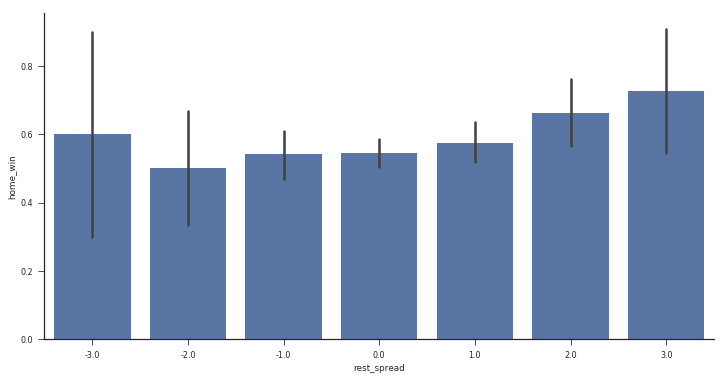

In [86]:
fig, ax = plt.subplots(figsize=(12, 6))
sns.barplot(x='rest_spread', y='home_win', data=df.query('-3 <= rest_spread <= 3'),
            color='#4c72b0', ax=ax)
sns.despine()

In [87]:
rest = (tidy.groupby(['date', 'variable'])
            .rest.mean()
            .dropna())
rest.unstack().head()

variable,away_team,home_team
date,,
2017-10-05,0.000000,NaN
2017-10-07,0.866667,1.166667
2017-10-08,0.000000,0.000000
2017-10-09,1.000000,1.285714
2017-10-10,1.428571,1.714286


In [88]:
rest.unstack().stack()

date        variable 
2017-10-05  away_team    0.000000
2017-10-07  away_team    0.866667
            home_team    1.166667
2017-10-08  away_team    0.000000
            home_team    0.000000
                           ...   
2018-04-06  home_team    1.000000
2018-04-07  away_team    0.533333
            home_team    1.000000
2018-04-08  away_team    0.000000
            home_team    0.000000
Length: 353, dtype: float64

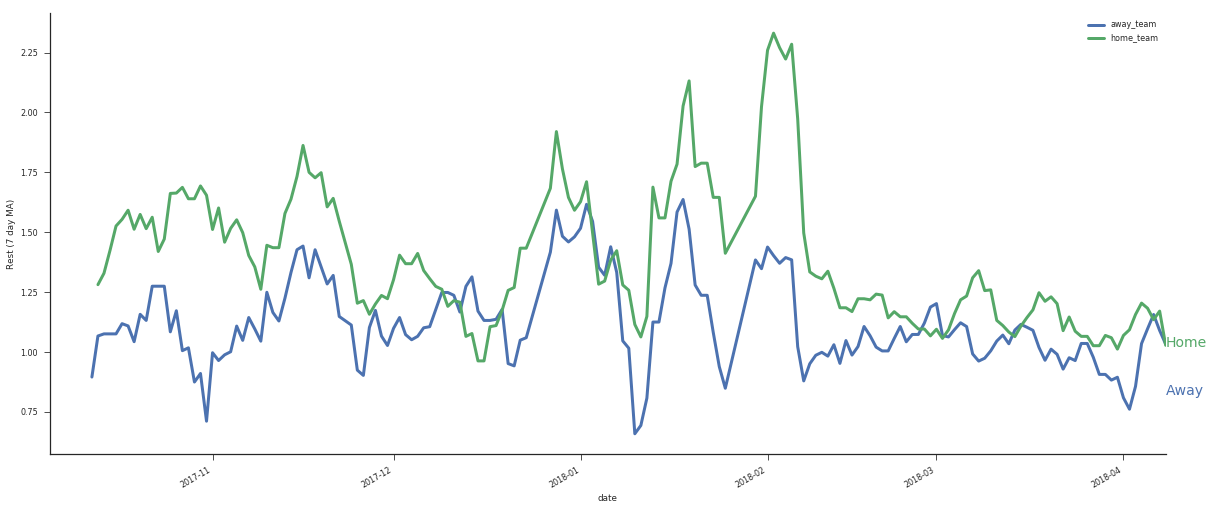

In [91]:
with sns.color_palette() as pal:
    b, g = pal.as_hex()[:2]

    
    ## Rolling Averages set to one due to small amount of time series data
ax=(rest.unstack().query('away_team < 7').rolling(7).mean().plot(figsize=(20, 9), linewidth=3, legend=False))
ax.set(ylabel='Rest (7 day MA)')
ax.annotate("Home", (rest.index[-1][0], 1.02), color=g, size=14)
ax.annotate("Away", (rest.index[-1][0], 0.82), color=b, size=14)
ax.legend()
sns.despine()

### Other Pandas Data Operations 

In [93]:
df['home_win'] = df.home_goals > df.away_goals

In [94]:
wins = (
    pd.melt(df.reset_index(),
            id_vars=['game_id', 'date', 'home_win'],
            value_name='team', var_name='is_home',
            value_vars=['home_team', 'away_team'])
   .assign(win=lambda x: x.home_win == (x.is_home == 'home_team'))
   .groupby(['team', 'is_home'])
   .win
   .agg(['sum', 'count', 'mean'])
   .rename(columns=dict(sum='n_wins',
                        count='n_games',
                        mean='win_pct'))
)
wins.head()

n_wins  n_games   win_pct
team            is_home                             
Anaheim Ducks   away_team    18.0       41  0.439024
                home_team    26.0       41  0.634146
Arizona Coyotes away_team    13.0       41  0.317073
                home_team    16.0       41  0.390244
Boston Bruins   away_team    22.0       41  0.536585

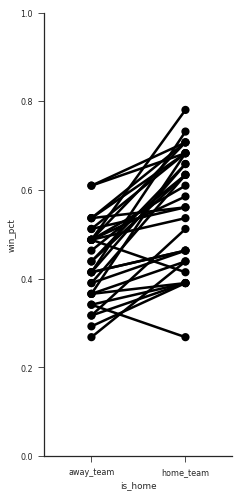

In [95]:
g = sns.FacetGrid(wins.reset_index(), hue='team', size=7, aspect=.5, palette=['k'])
g.map(sns.pointplot, 'is_home', 'win_pct').set(ylim=(0, 1));

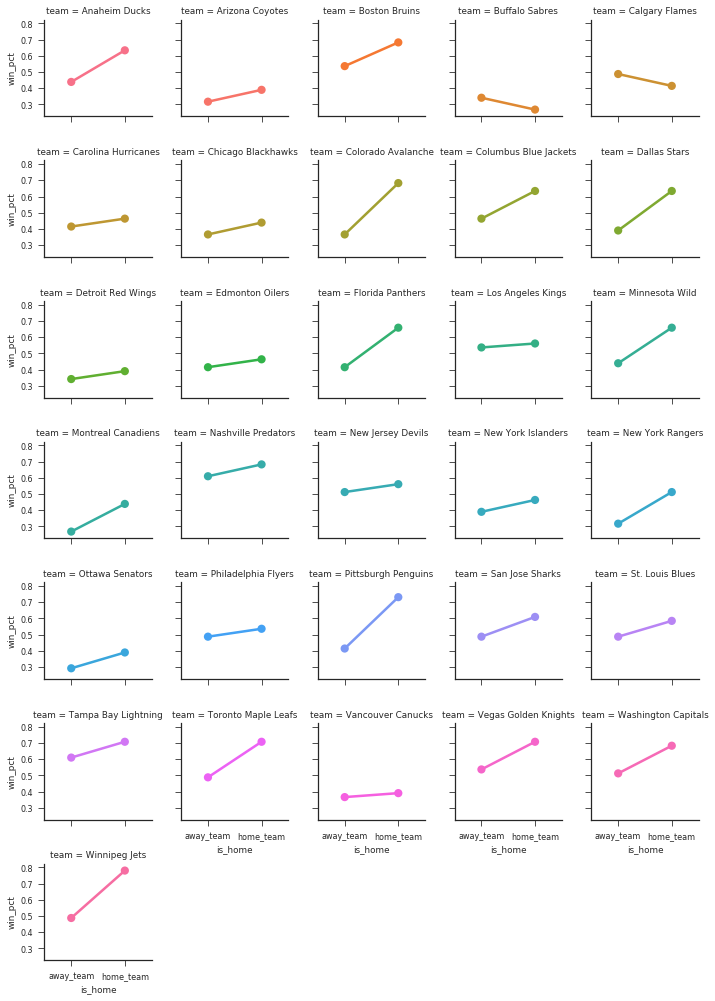

In [96]:
g = sns.FacetGrid(wins.reset_index(), col='team', hue='team', col_wrap=5, size=2)
g.map(sns.pointplot, 'is_home', 'win_pct')

In [97]:
win_percent = (
    # Use sum(games) / sum(games) instead of mean
    # since I don't know if teams play the same
    # number of games at home as away
    wins.groupby(level='team', as_index=True)
        .apply(lambda x: x.n_wins.sum() / x.n_games.sum())
)
win_percent.head()

team
Anaheim Ducks      0.536585
Arizona Coyotes    0.353659
Boston Bruins      0.609756
Buffalo Sabres     0.304878
Calgary Flames     0.451220
dtype: float64

Text(0.5,83.4,'Win Percent')

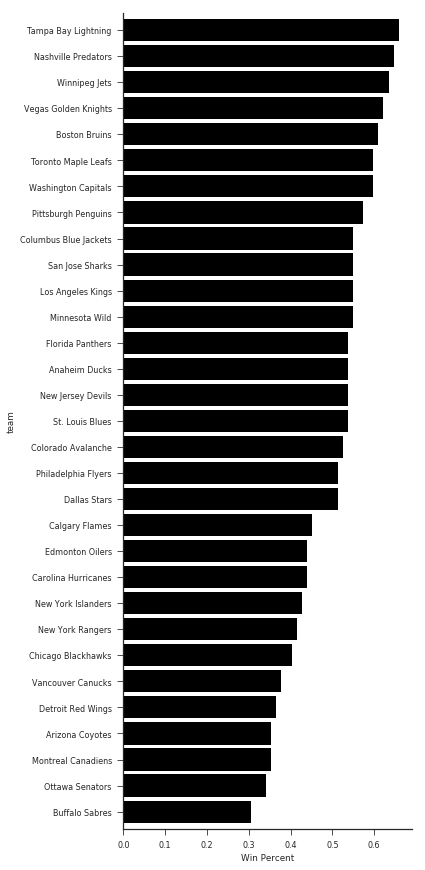

In [98]:
win_percent.sort_values().plot.barh(figsize=(6, 12), width=.85, color='k')
plt.tight_layout()
sns.despine()
plt.xlabel("Win Percent")

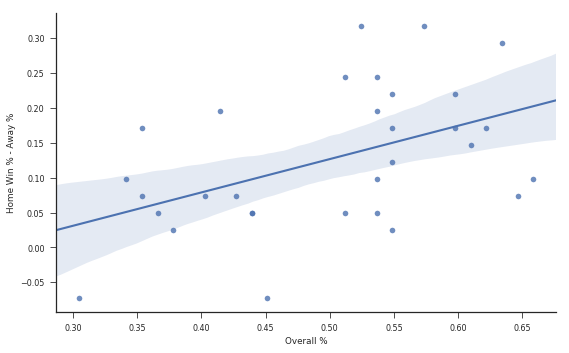

In [99]:
plt.figure(figsize=(8, 5))
(wins.win_pct
    .unstack()
    .assign(**{'Home Win % - Away %': lambda x: x.home_team - x.away_team,
               'Overall %': lambda x: (x.home_team + x.away_team) / 2})
     .pipe((sns.regplot, 'data'), x='Overall %', y='Home Win % - Away %')
)
sns.despine()
plt.tight_layout()

In [101]:
df = df.assign(away_strength=df['away_team'].map(win_percent),
               home_strength=df['home_team'].map(win_percent),
               point_diff=df['home_goals'] - df['away_goals'],
               rest_diff=df['home_rest'] - df['away_rest'])
df.head()

,,away_team,away_goals,home_team,home_goals,Overtime,away_rest,home_rest,home_win,rest_spread,away_strength,home_strength,point_diff,rest_diff
game_id,date,,,,,,,,,,,,,
0,2017-10-04,Calgary Flames,0,Edmonton Oilers,3,0,NaN,NaN,True,NaN,0.451220,0.439024,3,NaN
1,2017-10-04,St. Louis Blues,5,Pittsburgh Penguins,4,1,NaN,NaN,False,NaN,0.536585,0.573171,-1,NaN
2,2017-10-04,Philadelphia Flyers,5,San Jose Sharks,3,0,NaN,NaN,False,NaN,0.512195,0.548780,-2,NaN
3,2017-10-04,Toronto Maple Leafs,7,Winnipeg Jets,2,0,NaN,NaN,False,NaN,0.597561,0.634146,-5,NaN
4,2017-10-05,Arizona Coyotes,4,Anaheim Ducks,5,0,NaN,NaN,True,NaN,0.353659,0.536585,1,NaN


In [102]:
import statsmodels.formula.api as sm

df['home_win'] = df.home_win.astype(int)  # for statsmodels

In [104]:
mod = sm.logit('home_win ~ home_strength + away_strength + home_rest + away_rest', df)
res = mod.fit()
#res.summary()

Optimization terminated successfully.
         Current function value: 0.641862
         Iterations 5
